In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
# import line_profiler as lp 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wandb

import sys
sys.path.append('../src')
from model2D_v2 import *
from datagen2D_v2 import *
from analysis_v2 import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()
# torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

Running on GPU:  cuda:0


In [6]:
# constant_2D_ratinaboxnew_1000_40_256.npy, gradual_2D_ratinabox_2000_10_64.npy, 
# gradual_2D_ratinabox_5000_25_64.npy, constant_2D_ratinaboxnew_400_300_64.npy
# constant_2D_ratinaboxnew_1000_40_256.npy, constant_2D_bounded_hdv_randomstart_1000_40_256.npy
# constant_2D_5000_40_256.npy

In [14]:
config = {
    "learning_rate": 0.0002,
    "architecture": "CfC", # CfC, Ncp, Low, Lstm
    "dataset": "gradual_2D_ratinabox_5000_25_64.npy",
    "dataset_generator": "datagen2D_OU",
    "low": True,
    "lstm": True,  
    "hidden_size": 1024,
    "act_decay": 0.0,
    "weight_decay": 0.0,
    "act_decay_to_one": False,
    "h_bias": False,
    "input_bias": True,
    "rest_bias": None,
    "irnn": True,
    "activation": False, # None
    "clip_grad": 1.0,
    "optimizer": "SophiaG",
    "scheduler": None, # "StepLR"
    "if_scheduler": False,
    "scheduler_gamma" : 0.5,
    "scheduler_step" : 500,
    }

In [8]:
# run = wandb.init(
#     # set the wandb project where this run will be logged
#     project="RNN-Navigation-Representations",
    
#     # track hyperparameters and run metadata
#     config=config,
#     resume=True
# )
# config = wandb.config

In [15]:
input_data = np.load("../datasets/" + config["dataset"],allow_pickle=True)
config["epochs"] = input_data.shape[0]
config["batch_size"] = input_data[0,0].shape[0]
input_data[0,0].shape[0]

64

In [16]:
# lr=0.0002,if_low=False,act_decay=0.0,weight_decay=0.01,act_decay_to_one=False,h_bias=False,input_bias=True,rest_bias=True,irnn=True,activation=True,clip_grad=True,optimizer="Sophia"

lr = config["learning_rate"]
input_size = 2
hidden_size = config["hidden_size"]


model = CfC_NCP(input_size,hidden_size,if_low=config["low"],lr=lr).to(device)
if config["if_scheduler"]:
    model.activate_scheduler(step_size=config["scheduler_step"],gamma=config["scheduler_gamma"])
model_compiled = torch.compile(model)

train = False
if train:
    _ = model_compiled.train_gradual_manual(input_data)
    model.plot_losses(average=30)
    for i in range(len(model.task_losses)):
        wandb.log({"Task_loss": model.task_losses[i], "Total_loss": model.total_losses[i]})
else:
    torch.cuda.empty_cache()
    # model.load_state_dict(torch.load("../trained models/" + str(config.architecture) + "_" + str(run.id) + ".pt",map_location=device))
    model_compiled.load_state_dict(torch.load("../" + "CfC_lstm_N1024_5000gradual+400const_ratinabox_Sophia_200+300tsteps_actdecay_weightdecay_0.00005+0.00001lr.pt",map_location=device))
    # model.eval()

RuntimeError: Error(s) in loading state_dict for OptimizedModule:
	Missing key(s) in state_dict: "_orig_mod.input.weight", "_orig_mod.input.bias", "_orig_mod.inputx.bias", "_orig_mod.inputy.bias", "_orig_mod.output.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.h0_layer.weight", "_orig_mod.lstm.weight_ih", "_orig_mod.lstm.weight_hh", "_orig_mod.fc.weight", "_orig_mod.fc.bias", "_orig_mod.ltc.gleak", "_orig_mod.ltc.vleak", "_orig_mod.ltc.cm", "_orig_mod.ltc.sigma", "_orig_mod.ltc.mu", "_orig_mod.ltc.w", "_orig_mod.ltc.erev", "_orig_mod.ltc.sensory_sigma", "_orig_mod.ltc.sensory_mu", "_orig_mod.ltc.sensory_w", "_orig_mod.ltc.sensory_erev", "_orig_mod.ltc.sparsity_mask", "_orig_mod.ltc.sensory_sparsity_mask", "_orig_mod.ltc.input_w", "_orig_mod.ltc.input_b", "_orig_mod.ltc.output_w", "_orig_mod.ltc.output_b". 
	size mismatch for _orig_mod.cfc.layer_0.sparsity_mask: copying a param with shape torch.Size([612, 614]) from checkpoint, the shape in current model is torch.Size([614, 616]).
	size mismatch for _orig_mod.cfc.layer_0.ff1.weight: copying a param with shape torch.Size([612, 614]) from checkpoint, the shape in current model is torch.Size([614, 616]).
	size mismatch for _orig_mod.cfc.layer_0.ff1.bias: copying a param with shape torch.Size([612]) from checkpoint, the shape in current model is torch.Size([614]).
	size mismatch for _orig_mod.cfc.layer_0.ff2.weight: copying a param with shape torch.Size([612, 614]) from checkpoint, the shape in current model is torch.Size([614, 616]).
	size mismatch for _orig_mod.cfc.layer_0.ff2.bias: copying a param with shape torch.Size([612]) from checkpoint, the shape in current model is torch.Size([614]).
	size mismatch for _orig_mod.cfc.layer_0.time_a.weight: copying a param with shape torch.Size([612, 614]) from checkpoint, the shape in current model is torch.Size([614, 616]).
	size mismatch for _orig_mod.cfc.layer_0.time_a.bias: copying a param with shape torch.Size([612]) from checkpoint, the shape in current model is torch.Size([614]).
	size mismatch for _orig_mod.cfc.layer_0.time_b.weight: copying a param with shape torch.Size([612, 614]) from checkpoint, the shape in current model is torch.Size([614, 616]).
	size mismatch for _orig_mod.cfc.layer_0.time_b.bias: copying a param with shape torch.Size([612]) from checkpoint, the shape in current model is torch.Size([614]).
	size mismatch for _orig_mod.cfc.layer_1.sparsity_mask: copying a param with shape torch.Size([408, 1020]) from checkpoint, the shape in current model is torch.Size([408, 1022]).
	size mismatch for _orig_mod.cfc.layer_1.ff1.weight: copying a param with shape torch.Size([408, 1020]) from checkpoint, the shape in current model is torch.Size([408, 1022]).
	size mismatch for _orig_mod.cfc.layer_1.ff2.weight: copying a param with shape torch.Size([408, 1020]) from checkpoint, the shape in current model is torch.Size([408, 1022]).
	size mismatch for _orig_mod.cfc.layer_1.time_a.weight: copying a param with shape torch.Size([408, 1020]) from checkpoint, the shape in current model is torch.Size([408, 1022]).
	size mismatch for _orig_mod.cfc.layer_1.time_b.weight: copying a param with shape torch.Size([408, 1020]) from checkpoint, the shape in current model is torch.Size([408, 1022]).
	size mismatch for _orig_mod.cfc.layer_2.sparsity_mask: copying a param with shape torch.Size([4, 412]) from checkpoint, the shape in current model is torch.Size([2, 410]).
	size mismatch for _orig_mod.cfc.layer_2.ff1.weight: copying a param with shape torch.Size([4, 412]) from checkpoint, the shape in current model is torch.Size([2, 410]).
	size mismatch for _orig_mod.cfc.layer_2.ff1.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for _orig_mod.cfc.layer_2.ff2.weight: copying a param with shape torch.Size([4, 412]) from checkpoint, the shape in current model is torch.Size([2, 410]).
	size mismatch for _orig_mod.cfc.layer_2.ff2.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for _orig_mod.cfc.layer_2.time_a.weight: copying a param with shape torch.Size([4, 412]) from checkpoint, the shape in current model is torch.Size([2, 410]).
	size mismatch for _orig_mod.cfc.layer_2.time_a.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for _orig_mod.cfc.layer_2.time_b.weight: copying a param with shape torch.Size([4, 412]) from checkpoint, the shape in current model is torch.Size([2, 410]).
	size mismatch for _orig_mod.cfc.layer_2.time_b.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([2]).

In [ ]:
train2 = False

if train2:
    dataset = "gradual_2D_ratinabox_5000_25_64.npy"
    input_data = np.load("../datasets/" + dataset,allow_pickle=True)
    config.dataset = config.dataset + " + " + dataset

    _ = model_compiled.train_gradual_manual(input_data)
    model.plot_losses(average=30)
    for i in range(len(model.task_losses)):
        wandb.log({"Task_loss": model.task_losses[i], "Total_loss": model.total_losses[i]})
    

In [6]:
savemodel = True
logmodel = True

if savemodel:
    model_string = str(config.architecture) + "_" + str(run.id)
    model_path = "../trained models/" + model_string  + ".pt"
    torch.save(model.state_dict(), model_path)

if logmodel:
    model_art = wandb.Artifact(model_string, type='model')
    model_art.add_file(model_path)
    wandb.log_artifact(model_art)

# Analysis

In [7]:
an = Analysis(model,if_low=config.low)

## Activity/hidden state norms per tstep

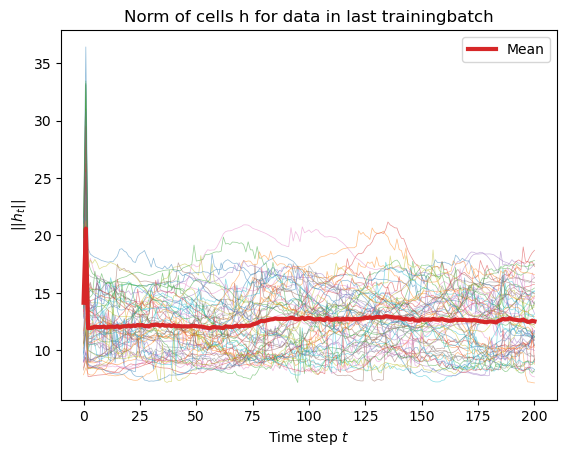

Mean norm:  12.50997


In [11]:
mean_norms = an.plot_norm(avg_only=False,skip_first=True)

# for norms in mean_norms:
#     wandb.log({'mean_norm_per_tstep': norms})

## Tuning curves

In [26]:
t_test = 40
test_batch_size = 5000
activity = an.binned_mean_activity(t_test=t_test,test_batch_size=test_batch_size,bins=50,circular=False)

100%|██████████| 256/256 [00:05<00:00, 50.59it/s]


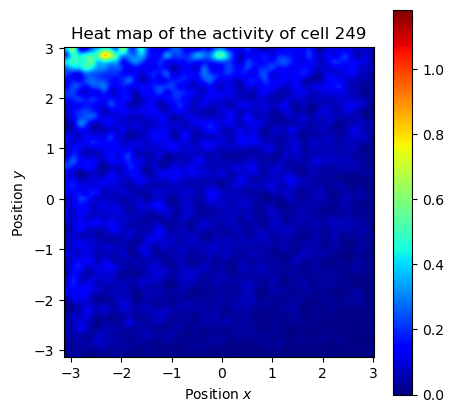

100%|██████████| 16/16 [00:00<00:00, 1751.50it/s]


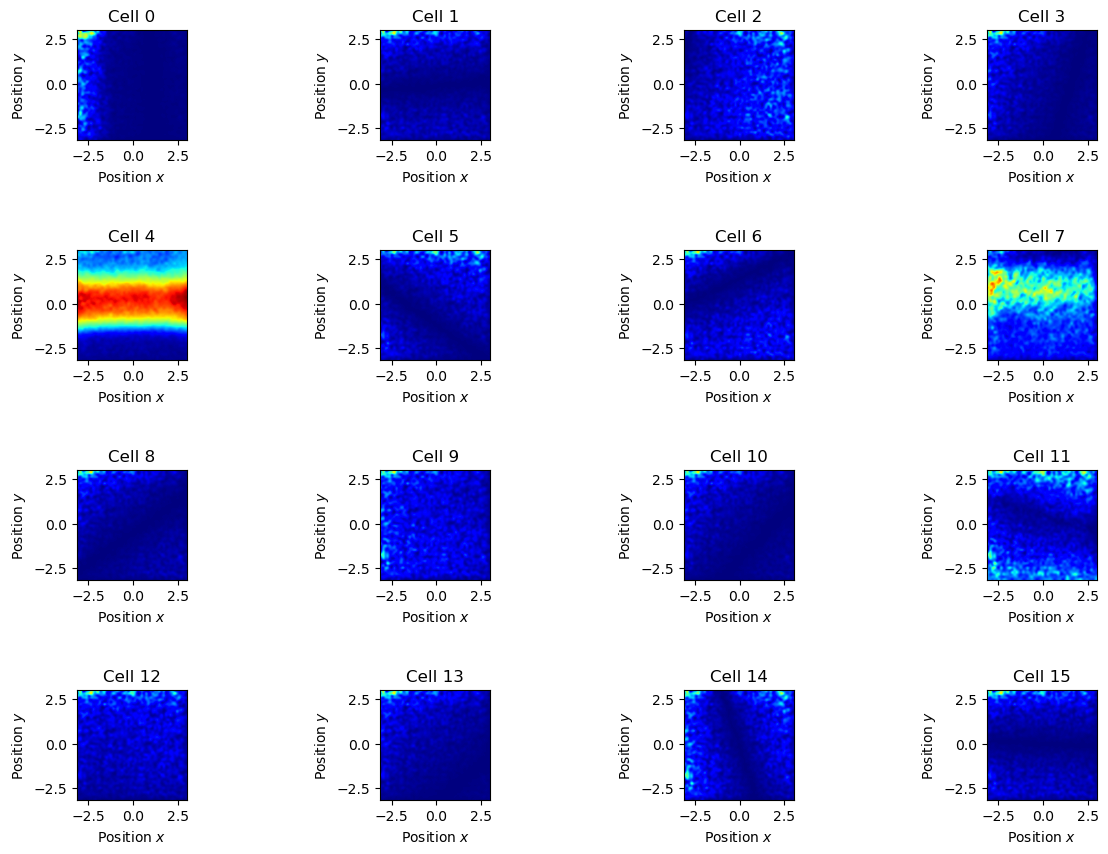

In [22]:
an.plot_2D_activity(k_test=249,more_plots=True,plot_head_frac=1/16)

In [23]:

# cells = [252,254,249,228,250]
cells = range(len(activity))
for cell in cells:
    normalized = (activity[cell] - np.min(activity[cell])) / (np.max(activity[cell]) - np.min(activity[cell]))
    images = wandb.Image(normalized, caption="Tuning Curves")
    wandb.log({"tuning_curves": images})

## Low-D Representation of activity

In [28]:
embedding, reducer = an.lowD_reduce(if_pca=False,n_components=3,plot=True,n_neighbors=500)

(2500, 3)


In [29]:
wandb.log({"Activity Representation": wandb.Object3D(embedding)})
wandb.log({"Circular activity": False})

## Path error

Total MSE:  0.35586807


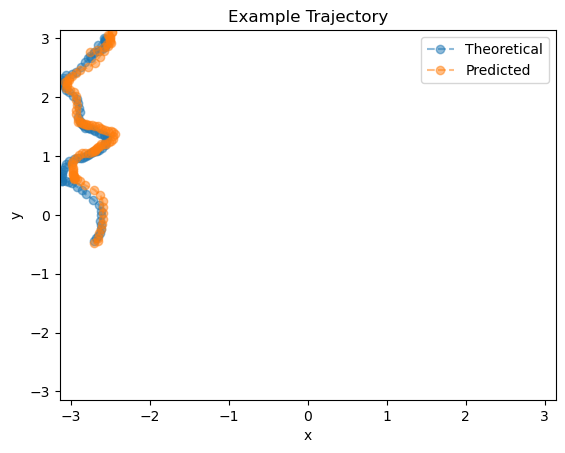

Mean error:  0.24676736
Mean end error:  0.29492918


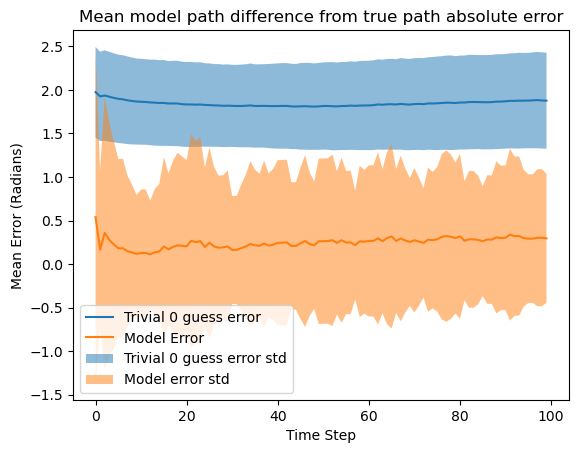

In [13]:
total_mse, path_err_mean, path_err_mean_std = an.eval(test_batch_size=1000,t_test=100,plot_example=True)

In [14]:
wandb.log({"Total MSE Error": total_mse})
for i in range(len(path_err_mean)):
    wandb.log({"Path MSE Error": path_err_mean[i]})
    wandb.log({"Path MSE Error STD": path_err_mean_std[i]})

In [15]:
run.finish()

Path MSE Error,█▅▂▂▁▁▂▂▃▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▄▃▄▄▃▄▄▄▄▄▄▄▅▄▄▄
Path MSE Error STD,█▆▃▂▂▁▃▃▃▄▄▂▁▂▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▃▃▁▂▂▂▃▃▂▂
Total MSE Error,▁
Circular activity,False
Path MSE Error,0.29493
Path MSE Error STD,0.74122
Task_loss,0.0243
Total MSE Error,0.35587
Total_loss,0.0243
mean_norm_per_tstep,12.52173
